## Section B

- Importing Libraries

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist
import pickle
from scipy.special import softmax

### Implementing Activation Functions and Gradients:
1. ReLU
2. Leaky ReLU
3. Sigmoid
4. Tanh
5. Linear 
6. Softmax

In [64]:
epsilon = 1e-8

# Define the following functions
# 1. sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))

# 2. relu
def relu(x):
    return np.where(x>0, x, 0)

def relu_grad(x):
    return np.where(x>0, 1, 0)

# 3. tanh
def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1-tanh(x)**2

# 4. leaky_relu
def leaky_relu(x, alpha=0.01):
    return np.where(x>0,x,alpha*x)

def leaky_relu_grad(x, alpha=0.01):
    return np.where(x>0,1,alpha)

# 5. linear
def linear(x):
    return x

def linear_grad(x):
    return np.ones_like(x)

def _softmax(x):
    # # Normalize x to avoid overflow by subtracting the max value from each row
    # exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    # return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    return softmax(x, axis=1)

def softmax_grad(x):
    return softmax(x, axis=1) * (1 - softmax(x, axis=1))


### Implementing Weight Initialisation Functions:
1. Zero Initialisation
2. Random Initialisation
3. Normal Initialisation N(0,1)

In [70]:
# Weight initialization functions

# 1. zero initialization
def zero_init(shape):
    return np.zeros(shape)

# 2. random initialization
def random_init(shape):
    weights = np.random.random(shape)*2-1

    # Scale the weights
    return weights/np.sqrt(np.sum(weights**2))

# 3. normal initialization
def normal_init(shape):
    weights_temp = np.random.normal(0,1,shape)

    # Scale the weights
    return weights_temp/np.sqrt(np.sum(weights_temp**2))
    # return np.random.normal(0,1,shape)

### Class Implementing Neural Network

In [66]:
class GoelNeuralNet:
    def __init__(self, N, A, activation, activation_grad, weight_init, num_epochs, batch_size, lr=0.01):
        """
        Initialize the neural network object with the following parameters:

        Parameters:
        N (int): Number of layers in the neural network
        A (list): List of number of neurons in each layer
        activation (function): Activation function to be used in forward propagation
        activation_grad (function): Gradient of the activation function
        weight_init (function): Weight initialization function
        num_epochs (int): Number of epochs to train the neural network
        batch_size (int): Batch size to use for training
        lr (float): Learning rate

        Weights and biases are initialized in the fit method. These are lists of numpy arrays. The weights are initialized using the
        weight_init function and the biases are initialized to zero. Weights is of shape (input_dim, output_dim) and biases is of shape
        (1, output_dim). The input_dim and output_dim are the number of neurons in the previous layer and the current layer respectively.
        The input_dim is the number of features in the input layer. The weights and biases are updated in the backward_propagation method.
        
        The activations are also initialized in the fit method. These are lists of numpy arrays which are of shape (batch_size, num_neurons).
        It stores the activations for each layer. The activations for the input layer are the input itself. 
        The activations for the hidden layers and the output layer are initialized to zero. The activations are updated in
        the forward_propagation method.
        """

        self.N = N
        self.A = A
        self.lr = lr
        self.activation = activation
        self.activation_grad = activation_grad
        self.weight_init = weight_init
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.activations = []

    def forward_propagation(self, X):
        """
        Perform forward propagation through the neural network and return the output which is the probability of each class. We pass 
        the input through each layer and apply the activation function to get the output of each layer. Finally, we apply softmax to the
        output of the last layer to get the probabilities of each class.
        
        Parameters:
        X (np.array): Input to the neural network (shape: (batch_size, input_dim))
        """

        self.activations[0] = X
        for i in range(self.N-1):
            X_temp = np.dot(self.activations[i],self.weights[i]) + self.biases[i]
            # If last layer apply softmax
            if i == self.N-2:
                X_activated = _softmax(X_temp)
            else:
                X_activated = self.activation(X_temp)
            self.activations[i+1] = X_activated
        return X_activated
    
    def backward_propagation(self, X, y, output):
        """
        For each layer, compute the gradients of the weights and biases and update them. Also, compute the error for the next layer. 
        We use error = (output - y) / batch_size. We clip the gradients to avoid exploding gradients. Finally, we update the weights
        and biases using the gradients and the learning rate. This is implementation of the backpropagation algorithm using chain rule.

        Parameters:
        X (np.array): Input to the neural network (shape: (batch_size, input_dim))
        y (np.array): Labels (shape: (batch_size, output_dim))
        output (np.array): Output of the neural network (shape: (batch_size, output_dim))
        """
        
        error = (output - y) / X.shape[0]  # Fix the error term dimensions

        for i in range(self.N - 2, -1, -1):
            # Compute gradients
            d_weights = np.dot(self.activations[i].T, error) 
            d_biases = np.sum(error, axis=0, keepdims=True) 

            """
            Gradient clipping (optional) is used to avoid exploding gradients. We clip the gradients to a maximum value of 15.0.
            """
            # max_grad = 15.0
            # d_weights = np.clip(d_weights, -max_grad, max_grad)
            # d_biases = np.clip(d_biases, -max_grad, max_grad)

            # Update weights and biases
            self.weights[i] -= self.lr * d_weights
            self.biases[i] -= self.lr * d_biases

            # Compute error for the next layer
            error = np.dot(error, self.weights[i].T) * self.activation_grad(self.activations[i])

        return error
    
    def fit(self, X, y, X_val, y_val):
        """
        Fit the neural network to the training data. We initialize the weights and biases. Then, we iterate over the epochs and for each
        epoch, we iterate over the batches. For each batch, we perform forward propagation and backward propagation. We compute the training
        and validation loss for each epoch and print it. Finally, we plot the training and validation losses.
        
        Parameters:
        X (np.array): Training data (shape: (num_samples, input_dim))
        y (np.array): Training labels (shape: (num_samples, output_dim))
        X_val (np.array): Validation data (shape: (num_samples, input_dim))
        y_val (np.array): Validation labels (shape: (num_samples, output_dim))
        """

        # Add input and output dimensions to the list of neurons in each layer
        input_dim = X.shape[1]
        output_dim = y.shape[1]
        self.A.insert(0,input_dim)
        self.A.append(output_dim)

        # Update number of layers
        self.N = self.N + 2

        # Initialize training and validation losses
        train_loss = []
        val_loss = []

        # Initialize weights and biases
        for i in range(len(self.A)-1):
            self.weights.append(self.weight_init((self.A[i],self.A[i+1])))
            self.biases.append(self.weight_init((1,self.A[i+1])))

        # Initialize activations
        self.activations = [X] + [np.zeros(shape) for shape in self.A[1:]]

        # Iterate over epochs
        for epoch in range(0, self.num_epochs):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:min(i+self.batch_size, X.shape[0])]
                y_batch = y[i:min(i+self.batch_size, X.shape[0])]

                # Forward pass
                y_pred = self.forward_propagation(X_batch)

                # Backward pass
                self.backward_propagation(X_batch, y_batch, y_pred)
            
            # Compute training loss
            y_pred_train = self.forward_propagation(X)
            training_loss = -np.sum(y*np.log(y_pred_train + 1e-6))/y.shape[0]
            
            # Compute validation loss
            y_pred_val = self.forward_propagation(X_val)
            validation_loss = -np.sum(y_val*np.log(y_pred_val + 1e-6))/y_val.shape[0]

            # Append training and validation losses
            train_loss.append(training_loss)
            val_loss.append(validation_loss)

            # Print training and validation losses
            print("Epoch: {} | Training loss: {} | Validation loss: {}".format(epoch+1, training_loss, validation_loss))

        # Plot training and validation losses at the end of training
        plt.plot(range(self.num_epochs), train_loss, label='Training Loss')
        plt.plot(range(self.num_epochs), val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict_proba(self, X):
        """
        Apply forward propagation and return the probabilities of each class for each row in X which is the output of
        the last layer of the neural network.
        
        Parameters:
        X (np.array): Input to the neural network (shape: (num_samples, input_dim)) which is the test data
        """

        # Call forward_propagation to get the probabilities for each class
        return self.forward_propagation(X)
    
    def predict(self, X):
        """
        Apply forward propagation and return the predicted class for each row in X. For each row, set the class with
        the highest probability to 1 and the rest to 0. This is the same as one-hot encoding the output of the neural
        network.

        Parameters:
        X (np.array): Input to the neural network (shape: (num_samples, input_dim)) which is the test data
        """
        # Call predict_proba to get the probabilities for each class
        y_pred_proba = self.predict_proba(X)

        # For each row, set the class with the highest probability to 1 and the rest to 0
        y_pred = np.zeros_like(y_pred_proba)
        y_pred[np.arange(len(y_pred_proba)), y_pred_proba.argmax(1)] = 1

        return y_pred
    
    def score(self, X, y): 
        """
        Calculate the accuracy of the neural network by comparing the predicted class and the actual class for each row in X.
        Return the mean accuracy.
        
        Parameters:
        X (np.array): Input to the neural network (shape: (num_samples, input_dim)) which is the test data
        y (np.array): Labels (shape: (num_samples, output_dim)) which is the test labels
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

### Showing Performance on the MNIST Dataset
- We first load the dataset and then configure the network according to the question.
- We then run it for each activation function and plot the val loss and train loss vs epochs curve

In [77]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the images
X_train = X_train/255.0
X_test = X_test/255.0

# Convert y to one-hot encoded vectors
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.transform(y_test.reshape(-1,1)).toarray()

In [78]:
# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define configurations
N = 4
A = [256, 128, 64, 32]
num_epochs = 20
batch_size = 128

Epoch: 1 | Training loss: 0.8789936472051718 | Validation loss: 0.8939582698992183
Epoch: 2 | Training loss: 0.7063265087055077 | Validation loss: 0.7155904201866458
Epoch: 3 | Training loss: 0.639232529443778 | Validation loss: 0.6398385505232325
Epoch: 4 | Training loss: 0.5743256875770706 | Validation loss: 0.6021550881063509
Epoch: 5 | Training loss: 0.5513204556936193 | Validation loss: 0.5777328154995722
Epoch: 6 | Training loss: 0.5133343490435059 | Validation loss: 0.5399611446192222
Epoch: 7 | Training loss: 0.4969683598240076 | Validation loss: 0.511742298119528
Epoch: 8 | Training loss: 0.46555089979118724 | Validation loss: 0.5040921770977106
Epoch: 9 | Training loss: 0.4635760149032969 | Validation loss: 0.49497091484769984
Epoch: 10 | Training loss: 0.4364448011224105 | Validation loss: 0.47775013267126376
Epoch: 11 | Training loss: 0.4394049283997687 | Validation loss: 0.48986484518907286
Epoch: 12 | Training loss: 0.4044827992273786 | Validation loss: 0.4545871407273532

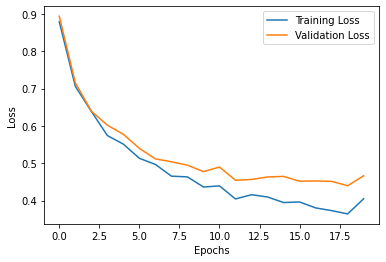

Validating the Tanh model:
Training accuracy: 0.9815125
Validation accuracy: 0.9807
Test accuracy: 0.98048


In [58]:
# Testing the model with various activation functions

# 1. Tanh activation function
model_tanh = GoelNeuralNet(N=N, A=A, lr=0.01, activation=tanh, activation_grad=tanh_grad, weight_init=normal_init, num_epochs=num_epochs, batch_size=batch_size)

# Train the model
model_tanh.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
print("Validating the Tanh model:")
print("Training accuracy: {}".format(model_tanh.score(X_train, y_train)))
print("Validation accuracy: {}".format(model_tanh.score(X_val, y_val)))
print("Test accuracy: {}".format(model_tanh.score(X_test, y_test)))

# Save the model
pickle.dump(model_tanh, open("model_tanh.pkl", "wb"))

Epoch: 1 | Training loss: 1.8515565592609375 | Validation loss: 1.8505750512800565
Epoch: 2 | Training loss: 1.5096650166340913 | Validation loss: 1.5081245619772115
Epoch: 3 | Training loss: 1.2858140741385327 | Validation loss: 1.2765724237725227
Epoch: 4 | Training loss: 1.1143229627372095 | Validation loss: 1.1009730751173197
Epoch: 5 | Training loss: 0.9914163176781343 | Validation loss: 0.9810300667249245
Epoch: 6 | Training loss: 0.9102047377168007 | Validation loss: 0.9041640481748328


/var/folders/c9/s8062nf53sv0b6gfv3ct0lv80000gn/T/ipykernel_31167/3519655299.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Epoch: 7 | Training loss: 0.8508608990190357 | Validation loss: 0.848009226823386
Epoch: 8 | Training loss: 0.8053429268625525 | Validation loss: 0.805795684292567
Epoch: 9 | Training loss: 0.7707453643898796 | Validation loss: 0.7696380324570582
Epoch: 10 | Training loss: 0.7369014315939747 | Validation loss: 0.7331835256703275
Epoch: 11 | Training loss: 0.7077895000171374 | Validation loss: 0.7019884081670116
Epoch: 12 | Training loss: 0.6837853190899783 | Validation loss: 0.6729529991799202
Epoch: 13 | Training loss: 0.6637137782728981 | Validation loss: 0.6490478763483956
Epoch: 14 | Training loss: 0.6461015760872518 | Validation loss: 0.6321930753785923
Epoch: 15 | Training loss: 0.6310522463695095 | Validation loss: 0.6162249662910024
Epoch: 16 | Training loss: 0.616727039184131 | Validation loss: 0.6032243139079833
Epoch: 17 | Training loss: 0.6042942781277718 | Validation loss: 0.5912941592885719
Epoch: 18 | Training loss: 0.5942928618916361 | Validation loss: 0.581646478288413

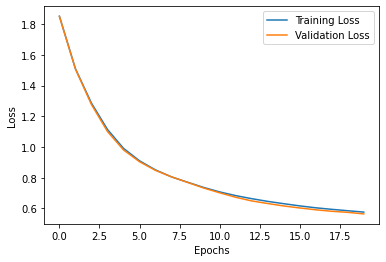

Validating the Sigmoid model:
Training accuracy: 0.9651708333333333
Validation accuracy: 0.96555
Test accuracy: 0.96608


In [62]:
# 2. Sigmoid activation function
model_sigmoid = GoelNeuralNet(N=N, A=A, lr=0.01, activation=sigmoid, activation_grad=sigmoid_grad, weight_init=normal_init, num_epochs=num_epochs, batch_size=batch_size)

# Train the model
model_sigmoid.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
print("Validating the Sigmoid model:")
print("Training accuracy: {}".format(model_sigmoid.score(X_train, y_train)))
print("Validation accuracy: {}".format(model_sigmoid.score(X_val, y_val)))
print("Test accuracy: {}".format(model_sigmoid.score(X_test, y_test)))

# Save the model
pickle.dump(model_sigmoid, open("model_sigmoid.pkl", "wb"))

Epoch: 1 | Training loss: 2.308493994911953 | Validation loss: 2.3088857841427854
Epoch: 2 | Training loss: 2.3026265778611394 | Validation loss: 2.3029857808960985
Epoch: 3 | Training loss: 2.301389217397443 | Validation loss: 2.301761708999418
Epoch: 4 | Training loss: 2.3011475603183427 | Validation loss: 2.3015343811167632
Epoch: 5 | Training loss: 2.3010985273634965 | Validation loss: 2.3014943034987767
Epoch: 6 | Training loss: 2.301086924389985 | Validation loss: 2.3014874810653363
Epoch: 7 | Training loss: 2.30108342453864 | Validation loss: 2.301486346929608
Epoch: 8 | Training loss: 2.3010820293833314 | Validation loss: 2.3014860705253724
Epoch: 9 | Training loss: 2.3010812983528535 | Validation loss: 2.301485853366488
Epoch: 10 | Training loss: 2.3010808101813165 | Validation loss: 2.301485597660525
Epoch: 11 | Training loss: 2.3010804185216474 | Validation loss: 2.301485311620109
Epoch: 12 | Training loss: 2.301080066129444 | Validation loss: 2.3014850093956816
Epoch: 13 | 

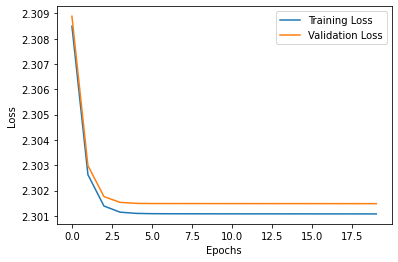

Validating the ReLU model:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


In [73]:
# 3. ReLU activation function
model_relu = GoelNeuralNet(N=N, A=A, lr=0.01, activation=relu, activation_grad=relu_grad, weight_init=normal_init, num_epochs=num_epochs, batch_size=batch_size)

# Train the model
model_relu.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
print("Validating the ReLU model:")
print("Training accuracy: {}".format(model_relu.score(X_train, y_train)))
print("Validation accuracy: {}".format(model_relu.score(X_val, y_val)))
print("Test accuracy: {}".format(model_relu.score(X_test, y_test)))

# Save the model
pickle.dump(model_relu, open("model_relu.pkl", "wb"))

Epoch: 1 | Training loss: 2.3101764784061585 | Validation loss: 2.3096257955455433
Epoch: 2 | Training loss: 2.3032219475143623 | Validation loss: 2.303166864695959
Epoch: 3 | Training loss: 2.3015085347046322 | Validation loss: 2.3017085135448725
Epoch: 4 | Training loss: 2.301151488510752 | Validation loss: 2.301469263704369
Epoch: 5 | Training loss: 2.3010882368439645 | Validation loss: 2.3014572479976794
Epoch: 6 | Training loss: 2.301080007138873 | Validation loss: 2.301470688668561
Epoch: 7 | Training loss: 2.301080179794314 | Validation loss: 2.3014799347046146
Epoch: 8 | Training loss: 2.3010808877879767 | Validation loss: 2.3014844410975095
Epoch: 9 | Training loss: 2.30108121183469 | Validation loss: 2.3014863662415865
Epoch: 10 | Training loss: 2.301081243830476 | Validation loss: 2.301487082538876
Epoch: 11 | Training loss: 2.301081119973113 | Validation loss: 2.3014872584272035
Epoch: 12 | Training loss: 2.301080918623839 | Validation loss: 2.3014871943454036
Epoch: 13 | T

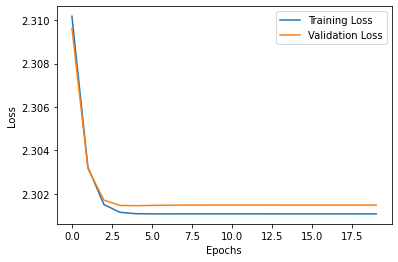

Validating the Leaky ReLU model:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


In [76]:
# 4. Leaky ReLU activation function
model_leaky_relu = GoelNeuralNet(N=N, A=A, lr=0.01, activation=leaky_relu, activation_grad=leaky_relu_grad, weight_init=normal_init, num_epochs=num_epochs, batch_size=batch_size)

# Train the model
model_leaky_relu.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
print("Validating the Leaky ReLU model:")
print("Training accuracy: {}".format(model_leaky_relu.score(X_train, y_train)))
print("Validation accuracy: {}".format(model_leaky_relu.score(X_val, y_val)))
print("Test accuracy: {}".format(model_leaky_relu.score(X_test, y_test)))

# Save the model
pickle.dump(model_leaky_relu, open("model_leaky_relu.pkl", "wb"))

Epoch: 1 | Training loss: 2.3081865286787977 | Validation loss: 2.308774521124939
Epoch: 2 | Training loss: 2.302046880736486 | Validation loss: 2.3024769470161286
Epoch: 3 | Training loss: 2.301180459050142 | Validation loss: 2.3015798689823934
Epoch: 4 | Training loss: 2.301079642609589 | Validation loss: 2.3014783825494556
Epoch: 5 | Training loss: 2.3010698343140663 | Validation loss: 2.301471825962795
Epoch: 6 | Training loss: 2.3010682134024956 | Validation loss: 2.301472522741749
Epoch: 7 | Training loss: 2.301066411189028 | Validation loss: 2.3014719367038894
Epoch: 8 | Training loss: 2.301064104066858 | Validation loss: 2.301470197816874
Epoch: 9 | Training loss: 2.3010615171795505 | Validation loss: 2.301467861695737
Epoch: 10 | Training loss: 2.301058775257556 | Validation loss: 2.3014652273852283
Epoch: 11 | Training loss: 2.3010559260152506 | Validation loss: 2.301462424074684
Epoch: 12 | Training loss: 2.301052982645876 | Validation loss: 2.3014595007715855
Epoch: 13 | Tr

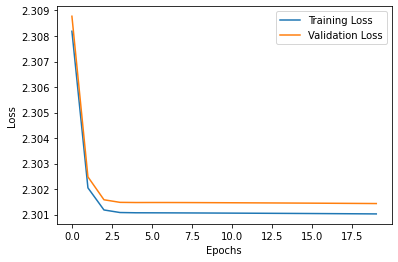

Validating the Linear model:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


In [79]:
# 5. Linear activation function
model_linear = GoelNeuralNet(N=N, A=A, lr=0.01, activation=linear, activation_grad=linear_grad, weight_init=random_init, num_epochs=num_epochs, batch_size=batch_size)

# Train the model
model_linear.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
print("Validating the Linear model:")
print("Training accuracy: {}".format(model_linear.score(X_train, y_train)))
print("Validation accuracy: {}".format(model_linear.score(X_val, y_val)))
print("Test accuracy: {}".format(model_linear.score(X_test, y_test)))

# Save the model
pickle.dump(model_linear, open("model_linear.pkl", "wb"))

### Validate Saved Models

In [80]:
# Load the models
model_tanh_loaded = pickle.load(open("model_tanh.pkl", "rb"))
model_sigmoid_loaded = pickle.load(open("model_sigmoid.pkl", "rb"))
model_relu_loaded = pickle.load(open("model_relu.pkl", "rb"))
model_leaky_relu_loaded = pickle.load(open("model_leaky_relu.pkl", "rb"))
model_linear_loaded = pickle.load(open("model_linear.pkl", "rb"))

# Evaluate the models
print("Testing Accuracies of the Models:")

print("Accuracy of the Tanh model: {}".format(model_tanh_loaded.score(X_test, y_test)))
print("Accuracy of the Sigmoid model: {}".format(model_sigmoid_loaded.score(X_test, y_test)))
print("Accuracy of the ReLU model: {}".format(model_relu_loaded.score(X_test, y_test)))
print("Accuracy of the Leaky ReLU model: {}".format(model_leaky_relu_loaded.score(X_test, y_test)))
print("Accuracy of the Linear model: {}".format(model_linear_loaded.score(X_test, y_test)))

Testing Accuracies of the Models:
Accuracy of the Tanh model: 0.98048


/var/folders/c9/s8062nf53sv0b6gfv3ct0lv80000gn/T/ipykernel_31167/2795428607.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy of the Sigmoid model: 0.96608
Accuracy of the ReLU model: 0.8227
Accuracy of the Leaky ReLU model: 0.8227
Accuracy of the Linear model: 0.8227
